In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier as NN

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm
from scipy.sparse import csr_matrix, csgraph

import numba
from numba import jit
from multiprocessing import Pool
from joblib import Parallel
import math, pickle


In [2]:
import dill
# to save the current session, uncomment the next line
# dill.dump_session("mnist_graph_construction.db")

# Load the previous session
dill.load_session("mnist_graph_construction.db")


In [16]:
# import pickle
# # Store individual objects (save them in sequential order)
# with open("inter_data.pickle", "wb") as inter_data_file:
#     pickle.dump(X, inter_data_file)
#     pickle.dump(y, inter_data_file)

# # Load individual objects (the order is the same as how they are stored)
# with open("inter_data.pickle", "rb") as inter_data_file:
#     pickled_X = pickle.load(inter_data_file)
#     pickled_y = pickle.load(inter_data_file)

In [3]:
# Load the dataset
# https://www.python-course.eu/neural_network_mnist.php
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "../data/raw_data/mnist/mnist_train.csv"
# train_data = np.loadtxt(data_path, delimiter=",")
# fac = 0.99 / 255
# train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
# train_ilabels = np.asfarray(train_data[:, :1]).ravel()

train_data = pd.read_csv(data_path, 
                        delimiter=",", header=None, dtype=np.uint8)
train_imgs = train_data.iloc[:, 1:]/255   # divide by 255 only for model prediction
train_imgs = train_imgs.astype("float32")
# train_imgs = train_data.iloc[:, 1:]
train_labels = np.asarray(train_data.iloc[:, :1][0])


In [4]:
# subsample the original dataset, each digit has 1000 instances rather than 5000-6000

all_indices = []
# for digit in [0, 1, 2, 4, 7, 8, 9]:
for digit in np.arange(0,10):
    single_digit_indices = set(np.where(train_labels == digit)[0][:1000])
    all_indices = set(all_indices).union(single_digit_indices)
print(len(all_indices))

X = train_imgs.iloc[list(all_indices), :]
y = train_labels[list(all_indices)]


10000


In [3]:

@jit(nopython=True)
def calculate_weighted_distance(v0, v1, penalty_term = 2):
    diff = np.subtract(v0, v1)
    reweight_vector = np.where(diff>=0, 1, -penalty_term)
    weighted_diff = np.linalg.norm(diff*reweight_vector)
    return weighted_diff

def get_weights_kNN(
    X, 
    n_neighbours = 20,
    penalty_term = 2,
    weight_func = None 
    ):
    n_samples, n_ftrs = X.shape
    
    k = np.zeros((n_samples, n_samples))
    W = k
    X = X.to_numpy()

    for i in tqdm(range(n_samples)):
        v0 = X[i]
        for j in range(n_samples):
            v1 = X[j]
            # modify the distance function so that removing pixels incurring larger cost.
            dist = calculate_weighted_distance(v1, v0, penalty_term=penalty_term)
            # dist = np.linalg.norm(v0 - v1)
            k[i, j] = dist
            if dist != 0:
                W[i,j] = weight_func(dist)
        
        t = np.argsort(k[i, :])[(n_neighbours+1):]
        mask = np.ix_(t)
        k[i, mask] = 0
        W[i, mask] = 0
        
    return W


In [6]:
clf = NN(max_iter=5000).fit(X, y)

In [7]:
predictions = clf.predict_proba(X)

In [5]:
def construct_graph(weight_matrix):
    graph = csr_matrix(weight_matrix)
    return graph

def find_shortest_path(graph, start_point_idx):
    dist_matrix, predecessors = csgraph.dijkstra(
        csgraph=graph, directed=True, indices=start_point_idx, return_predecessors=True
    )
    return dist_matrix, predecessors

def reconstruct_shortest_path(predecessors, start_point_idx, end_point_idx):
    """Get all the nodes along the path between the start point and the end point. 

    Args:
        predecessors (matrix of shape (1, n_nodes)): contain the previous node in the path.
        start_point_idx (int): the index of the start data point
        end_point_idx (int): the index of the end data point

    Returns:
        node_path (list): [start_point_idx, intermedium points index, end_point_idx]
    """
    if predecessors[end_point_idx] == start_point_idx:
        node_path = [end_point_idx]
    else:
        node_path = []
    intermedium_idx = end_point_idx
    while (predecessors[intermedium_idx] != start_point_idx):
        node_path.append(intermedium_idx)
        intermedium_idx = predecessors[intermedium_idx]
    if intermedium_idx != node_path[-1]:
        node_path.append(intermedium_idx)
    node_path.append(start_point_idx)
    
    return node_path[::-1]
 
def build_symmetric_matrix(kernel):
    for i in range(kernel.shape[0]):
        for j in range(i):
            kernel[j, i] = kernel[i,j]
    return kernel

def build_asymmetric_matrix(kernel, X, weight_func, penalty_term):
    n_samples = kernel.shape[0]
    X = X.to_numpy()
    for i in tqdm(range(n_samples)):
        for j in range(n_samples):
            if kernel[i,j] != 0:
                v0 = X[i]
                v1 = X[j]
                dist = calculate_weighted_distance(v0, v1, penalty_term=penalty_term)
                kernel[j, i] = weight_func(dist)
    return kernel

In [5]:
n_neighbours = 20
penalty_term = 1.1
n_samples, n_features = X.shape

def get_volume_of_sphere(d):
    return math.pi**(d/2)/math.gamma(d/2 + 1)

volume_sphere = get_volume_of_sphere(1)
r = (n_neighbours / (n_samples * volume_sphere))

# Construct the global weighted graph.
# Kernel is asymmetric if using KNN to get weight, and OG only keeps the bottom left half of the matrix
weight_func=lambda x: -x*np.log(r/x)  # x**alpha
kernel = get_weights_kNN(
            X,
            penalty_term=penalty_term,
            n_neighbours=int(n_neighbours),
            weight_func=weight_func
        )

# sym_kernel = build_symmetric_matrix(kernel)
# asym_kernel = build_asymmetric_matrix(kernel, X, weight_func, penalty_term=penalty_term)

# Replace FOR with parallel FOR (multi-processors emia..)
# On local laptop, set the number of processors to 2
# On server, set the number of processors to #of available - 1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [15]:
asym_kernel = build_asymmetric_matrix(kernel, X, weight_func, penalty_term)

# dill.dump_session("mnist_graph_construction.db")

  0%|          | 43/10000 [00:00<00:24, 405.84it/s]

100%|██████████| 10000/10000 [00:19<00:00, 503.93it/s]


In [6]:
def get_minimum_dist(dist_matrix):
    """get the shortest distance and its data index
    Args:
        dist_matrix (array): shape: 1 x n_nodes

    Returns:
        min_dist: minimum distance in the distance matrix
        min_dist_idx: index of the data point with the shortest dist
    """
    min_dist = np.min(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False)) 
    min_dist_idx = np.argmin(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False))
    return min_dist, min_dist_idx

def get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths = 1, pred_threshold=0.55):
    assert num_paths > 0 and isinstance(num_paths, int), "only positive integers"
    end_point_idx = []
    path_count = 0
    for idx in np.argsort(np.ma.masked_where(dist_matrix==0, dist_matrix)):
        if (y[idx] == target_class and
        predictions[idx, class_labels.index(target_class)] >= pred_threshold): 
            end_point_idx.append(idx)
            if path_count >= num_paths-1:
                break
            else:
                path_count += 1
    return end_point_idx

def get_user_agency(sp_graph, start_point_idx, alternative_classes, predictions, y, class_labels, pred_threshold=0.55):
    dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx)
    alt_class_dict = {}
    alt_path_dict = {}
    for alt_class in alternative_classes:
        alt_end_idx = get_closest_cf_point(dist_matrix, predictions, y, alt_class, class_labels, pred_threshold = pred_threshold)
        alt_end_dist = dist_matrix[alt_end_idx[0]]
        alt_class_dict[alt_class] = {alt_end_idx[0]: alt_end_dist}
        
        alt_end_path = reconstruct_shortest_path(predecessors, start_point_idx, alt_end_idx[0])
        alt_path_dict[alt_class] = {alt_end_idx[0]: alt_end_path}
    
    return alt_class_dict, alt_path_dict

In [7]:
np.where(y==1)[0][:20]

array([  3,   6,   8,  14,  23,  24,  40,  59,  67,  70,  72,  77,  78,
        99, 102, 104, 105, 112, 113, 124], dtype=int64)

In [162]:
# [7->2] 728, 1614
# [7->4] 728, 7770, 7350
# [7->3] 728, 8012
# [7->5] 728, 1088, 778
# [7->6] 728, 5650, 1031, 9676 
# [7->8] 728, 3003

array([ 1,  7, 13, 19, 36, 41, 43, 44, 46, 65], dtype=int64)

In [23]:
def calculate_dist_alter_cf(sp_graph, predictions, y, class_labels, inter_point_idx, target_class):
    dist_matrix_alter, predecessors_alter = find_shortest_path(sp_graph, start_point_idx=inter_point_idx)
    end_point_idx_alter = get_closest_cf_point(dist_matrix_alter, predictions, y, target_class, class_labels, num_paths=1)
    shortest_path_alter = reconstruct_shortest_path(predecessors_alter, start_point_idx=inter_point_idx, end_point_idx=end_point_idx_alter[0])
    # plot_digits(shortest_path_alter)
    dist = dist_matrix_alter[end_point_idx_alter[0]]
    return dist

# single class
def calculate_shared_perc(dist_matrix, path_idx, params, alter_class):
    point_count = len(path_idx)
    if point_count == 2:    # no intermediate points
        final_point_dist = calculate_dist_alter_cf(params["sp_graph"], params["predictions"], params["y"], params["class_labels"], path_idx[1], target_class=alter_class)
        start_point_dist = calculate_dist_alter_cf(params["sp_graph"], params["predictions"], params["y"], params["class_labels"], path_idx[0], target_class=alter_class)
        # print(start_point_dist, final_point_dist)
        if final_point_dist > start_point_dist:
            shared_perc = 0
        else:
            shared_perc = 1
    else:
        for i in range(point_count-2):
            current_point_dist = calculate_dist_alter_cf(params["sp_graph"], params["predictions"], params["y"], params["class_labels"], path_idx[i], target_class=alter_class)
            next_point_dist = calculate_dist_alter_cf(params["sp_graph"], params["predictions"], params["y"], params["class_labels"], path_idx[i+1], target_class=alter_class)
            # print(current_point_dist, next_point_dist)
            if next_point_dist > current_point_dist:
                termination_point = path_idx[i]
                break
            else:
                termination_point = path_idx[i+1]
        shared_perc = dist_matrix[termination_point]/dist_matrix[path_idx[-1]]
    return shared_perc

def calculate_avg_shared_perc(dist_matrix, path_idx, params, alter_classes):
    avg_shared_perc_list = []
    for y_prime in alter_classes:
        shared_perc = calculate_shared_perc(dist_matrix, path_idx, params, y_prime)
        avg_shared_perc_list.append(shared_perc)
        # print(shared_perc)
    avg_shared_perc = np.mean(avg_shared_perc_list)
    # std_shared_perc = np.std(avg_shared_perc_list)
    return avg_shared_perc


def find_highest_shared_perc(dist_matrix, params, alter_classes, all_paths, top_num=5):
    all_paths_dict = list(all_paths.values())[0]
    highest_shared_perc = 0
    highest_path_id = None
    shortest_path_info = {
        "dist": dist_matrix[all_paths_dict[0][-1]],
        "path_rank": 0,
        "path_shared_perc": calculate_avg_shared_perc(dist_matrix, all_paths_dict[0], params, alter_classes)
    }
    for count, path_idx in all_paths_dict.items():
        if count >= top_num:
            break
        avg_shared_perc = calculate_avg_shared_perc(dist_matrix, path_idx, params, alter_classes)
        # print(avg_shared_perc)
        if avg_shared_perc > highest_shared_perc:
            highest_shared_perc = avg_shared_perc
            highest_path_id = count

    highest_shared_path_info = {
        "dist": dist_matrix[all_paths_dict[highest_path_id][-1]],
        "path_rank": highest_path_id,
        "path_shared_perc": highest_shared_perc
    }
    return shortest_path_info, highest_shared_path_info

params = {
    "sp_graph": sp_graph,
    "predictions": predictions,
    "y": y,
    "class_labels": list(map(int, clf.classes_)),
}
alter_classes = [0, 2, 3, 4, 5, 6, 7, 8]
# calculate_dist_alter_cf(sp_graph, predictions, y, class_labels, inter_point_idx=3, target_class=9)
# shared_perc = calculate_shared_perc(dist_matrix, [3, 573, 1521, 3457, 7335], params, alter_class=3)

avg_shared_perc = calculate_avg_shared_perc(dist_matrix, [7454, 2047, 7185, 5564, 864], params, alter_classes)
print(avg_shared_perc)
# find_highest_shared_perc(dist_matrix, params, alter_classes, res)


0.40791125749535784


In [20]:
def find_paths_for_one(sp_graph, start_point_idx, target_class, params, num_paths):
    res = {}
    res[start_point_idx] = {}
    dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx=start_point_idx)

    end_point_indices = get_closest_cf_point(dist_matrix, params["predictions"], params["y"], target_class, params["class_labels"], num_paths=num_paths)
    # print(end_point_indices)

    for order, end_point_idx in enumerate(end_point_indices):
        shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=end_point_idx)
        # flag = 0
        for node_idx in shortest_path[:-1]:
            # print(np.argmax(predictions[node_idx]))
            if np.argmax(predictions[node_idx]) not in [1, target_class]:
                flag = 1
            # alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
            # alt_class_dict, alt_path_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
            # print("node index: ", node_idx)
            # print(alt_class_dict)
        # if flag == 1:
            res[start_point_idx][order] = shortest_path
    # print(res)
    return res, dist_matrix

sp_graph = construct_graph(kernel)
start_point_idx = 3     # 728
target_class = 9
params = {
    "sp_graph": sp_graph,
    "predictions": predictions,
    "y": y,
    "class_labels": list(map(int, clf.classes_)),
}
alter_classes = [0, 2, 3, 4, 5, 6, 7, 8]
# alternative_classes = list(set(class_labels) - set([target_class, y[start_point_idx]]))
all_paths, dist_matrix = find_paths_for_one(sp_graph, start_point_idx, target_class, params, num_paths=25)
shortest_path_info, highest_shared_path_info = find_highest_shared_perc(dist_matrix, params, alter_classes, all_paths, top_num=5)
print(all_paths)
print(shortest_path_info)
print(highest_shared_path_info)

{3: {0: [3, 671, 3510], 1: [3, 23, 8185, 7233], 2: [3, 5749, 1497, 641], 3: [3, 8161, 1031, 7365], 4: [3, 7454, 2426, 3598], 5: [3, 4105, 7278, 2997], 6: [3, 23, 8185, 7233, 1455], 7: [3, 573, 4137, 1547, 1441], 8: [3, 23, 8185, 7233, 583], 9: [3, 4149, 8765, 5233], 10: [3, 573, 4137, 1547, 1585], 11: [3, 23, 8185, 7233, 8287], 12: [3, 4149, 8765, 1465], 13: [3, 4129, 4063, 5454], 14: [3, 573, 1521, 3457, 7335], 15: [3, 23, 8185, 7233, 501], 16: [3, 23, 8185, 3455, 3511], 17: [3, 23, 1597, 8415, 529], 18: [3, 7454, 2047, 7149, 3703, 3355], 19: [3, 23, 8185, 3455, 3621], 20: [3, 7454, 2047, 7185, 5564, 864], 21: [3, 23, 8185, 3455, 7381], 22: [3, 23, 8185, 7233, 487], 23: [3, 573, 4137, 1547, 3311], 24: [3, 7454, 4685, 137, 7518]}}
{'dist': 72.82598875718745, 'path_rank': 0, 'path_shared_perc': 0.18132101106304502}
{'dist': 108.70652210535981, 'path_rank': 3, 'path_shared_perc': 0.5540492994715015}


In [182]:
all_one_indices = list(np.where(y==1)[0])[:100]
face_shared_perc_list = []
face_dist_list = []
facelift_shared_perc_list = []
facelift_dist_list = []
common_count = 0

for factual_point_idx in all_one_indices:
    all_paths, dist_matrix = find_paths_for_one(sp_graph, factual_point_idx, target_class, params, num_paths=5)
    shortest_path_info, highest_shared_path_info = find_highest_shared_perc(dist_matrix, params, alter_classes, all_paths, top_num=5)
    face_shared_perc_list.append(shortest_path_info["path_shared_perc"])
    face_dist_list.append(shortest_path_info["dist"])
    facelift_shared_perc_list.append(highest_shared_path_info["path_shared_perc"])
    facelift_dist_list.append(highest_shared_path_info["dist"])
    if shortest_path_info["path_rank"] == highest_shared_path_info["path_rank"]:
        common_count += 1
    
print("shared percentage of paths from face: {}, std: {}".format(round(np.mean(face_shared_perc_list), 2), round(np.std(face_shared_perc_list), 2)))
print("average distance of shortest path: {}, std: {} ".format(round(np.mean(face_dist_list), 2), round(np.std(face_dist_list), 2)))
print("shared percentage of paths from facelift: {}, std: {}".format(round(np.mean(facelift_shared_perc_list), 2), round(np.std(facelift_shared_perc_list), 2)))
print("average distance of path with maximised shared percentage: {}, std: {}".format(round(np.mean(facelift_dist_list), 2), round(np.std(facelift_dist_list), 2)))
print("common count: ", common_count)


shared percentage of paths from face: 0.23, std: 0.1
average distance of shortest path: 79.33, std: 16.19 
shared percentage of paths from facelift: 0.35, std: 0.09
average distance of path with maximised shared percentage: 103.95, std: 16.61
common count:  16


In [ ]:
# dill.dump_session("mnist_graph_construction.db")

In [12]:
def plot_digits(path):
    n_digits = len(path)
    ncols=min(10, n_digits)
    nrows = math.ceil(n_digits / ncols)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))
    axes = axes.ravel()
    for idx, img_idx in enumerate(path):
        ax = axes[idx]
        image = np.array(X.iloc[img_idx, :])
        label = y[img_idx]
        ax.set_axis_off()
        ax.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f"id:{img_idx}, t: {label}")
    plt.savefig(f'figures/example_{img_idx}_log.pdf', dpi=300)

def print_alt_paths(alt_path_dict):
    for alt_class, alt_class_path in alt_path_dict.items():
        plot_digits(list(alt_class_path.items())[0][1], '-'.join(map(str, [alt_class, 0])))

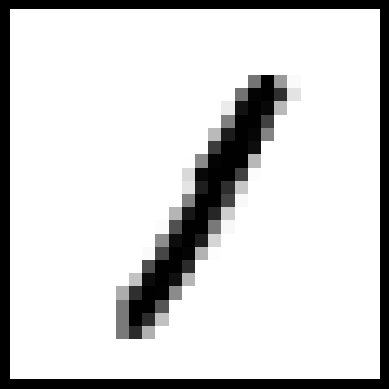

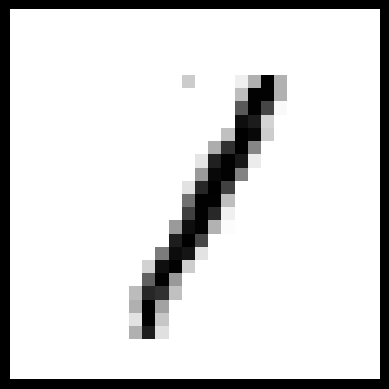

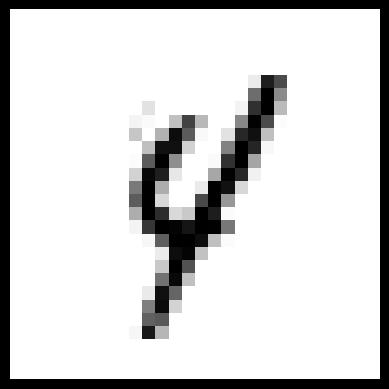

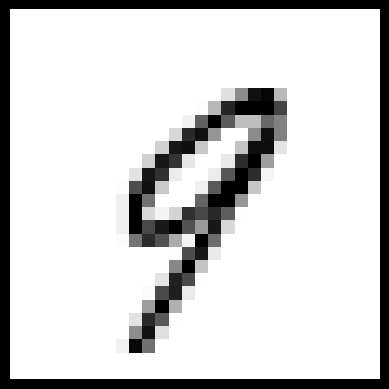

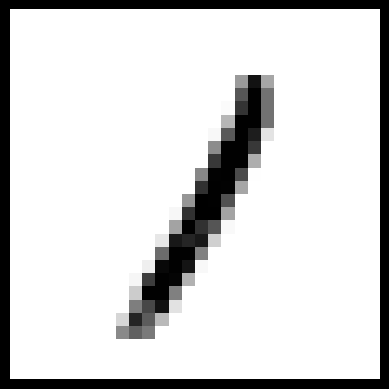

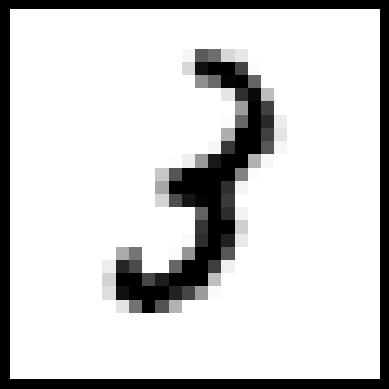

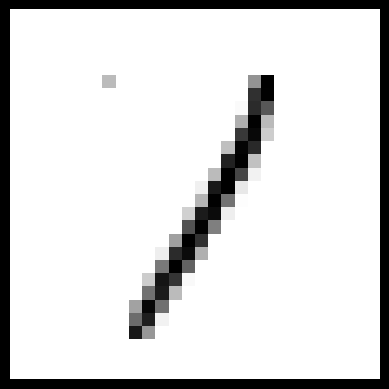

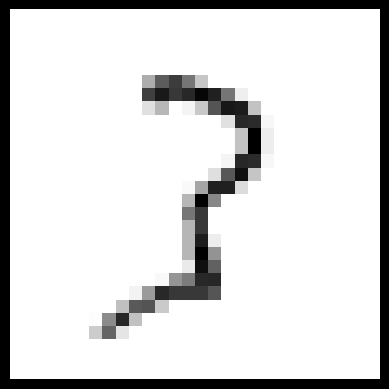

In [204]:
# img_indices = [61, 4205, 7227, 5749, 9681, 5287, 8315, 2449, 9681, 61, 8185, 3455]
img_indices = [573, 1521, 3457, 7335, 3487, 2132, 1031, 6858]
for img_idx in img_indices:
    digit1 = np.array(X.iloc[img_idx, :])
    fig, ax = plt.subplots()
    ax.set_axis_off()
    ax.imshow(digit1.reshape(28,28), cmap=plt.cm.gray_r, interpolation=None)
    plt.savefig(f'figures/digit_id_{img_idx}.pdf', dpi=300)


C:\Users\s3964913\AppData\Local\Temp\ipykernel_21660\3524353289.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))


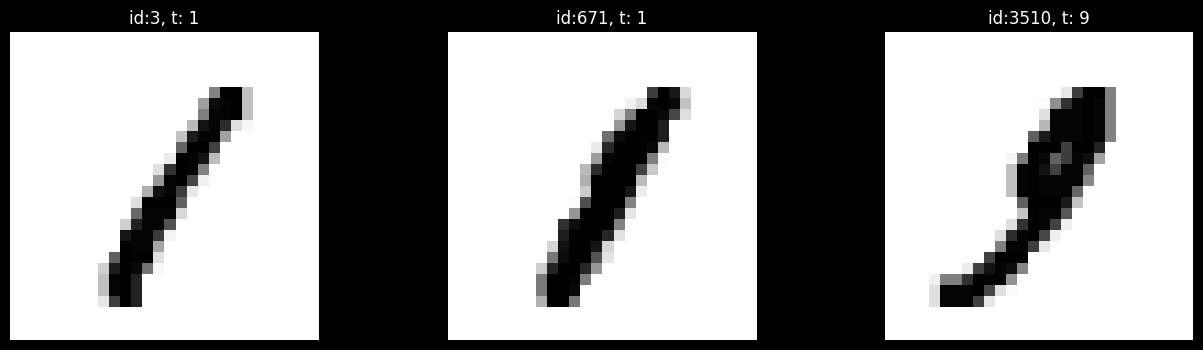

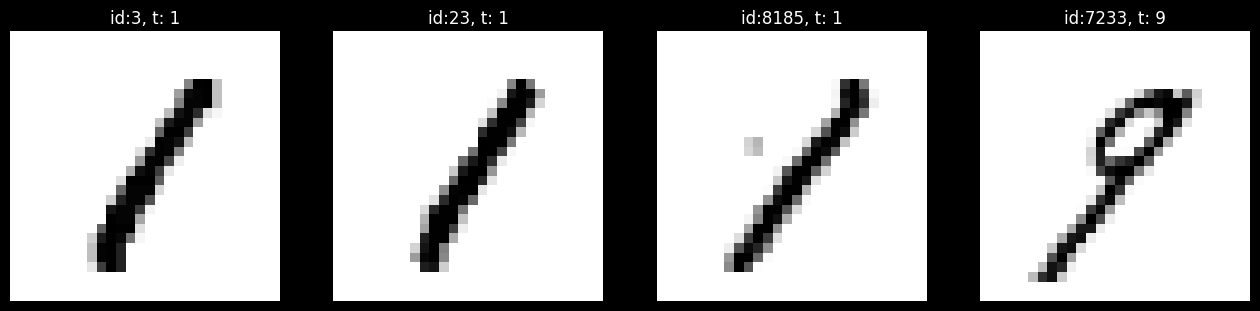

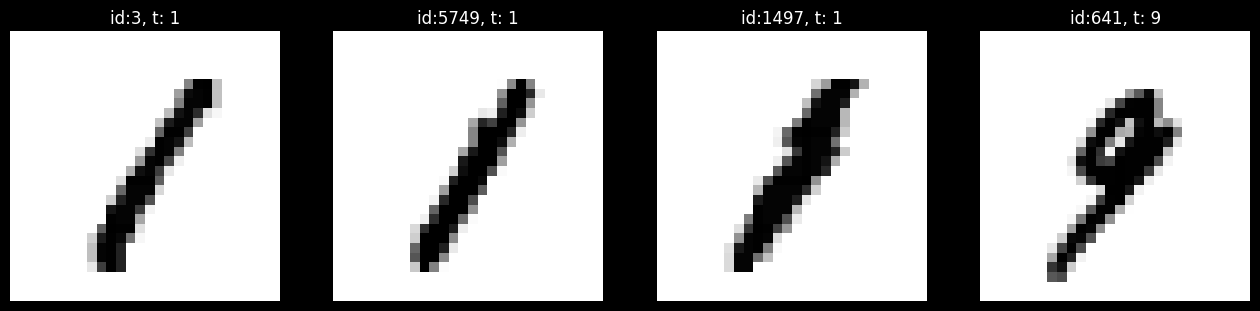

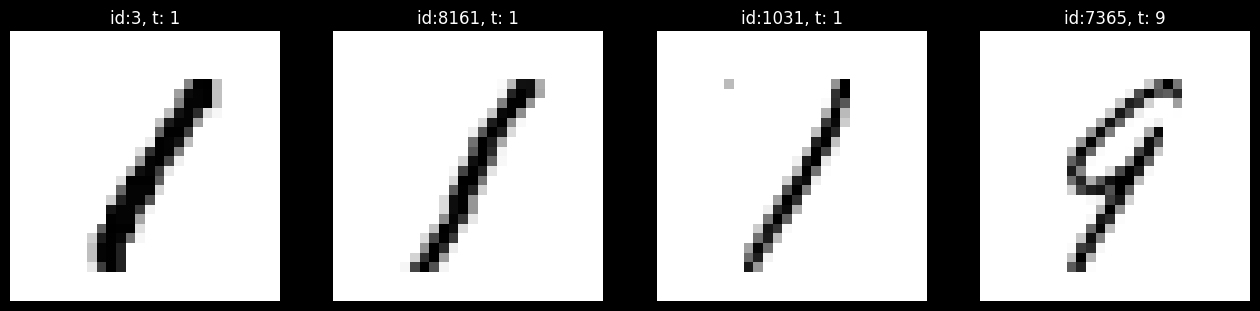

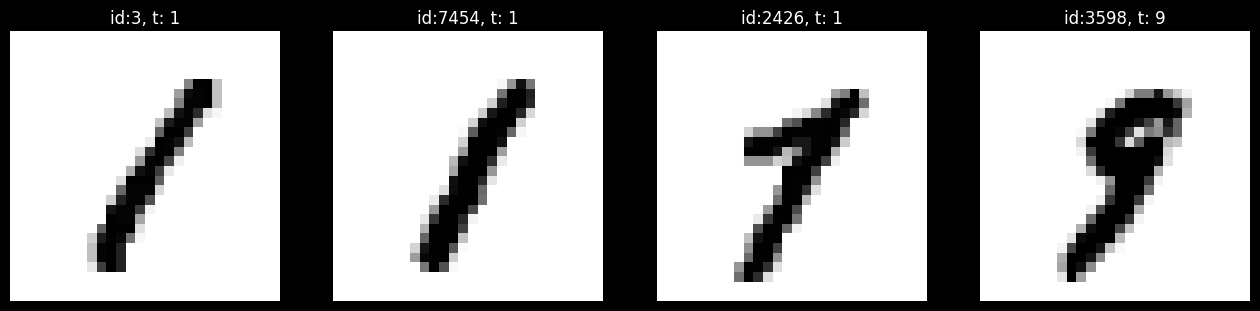

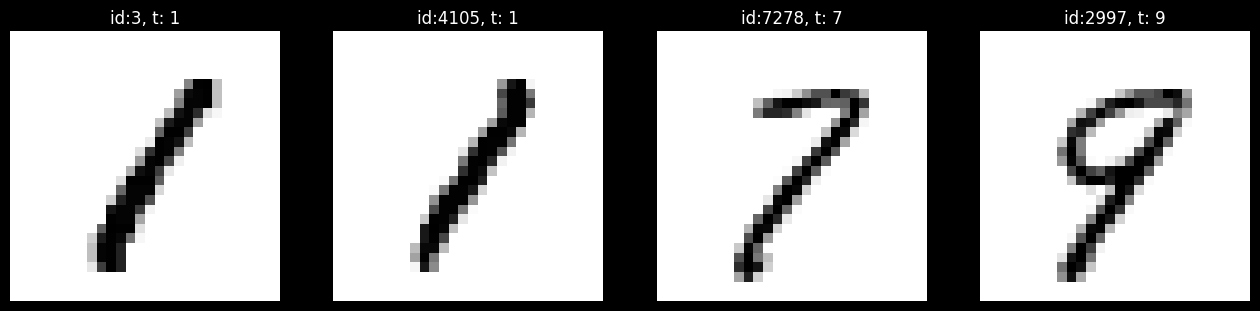

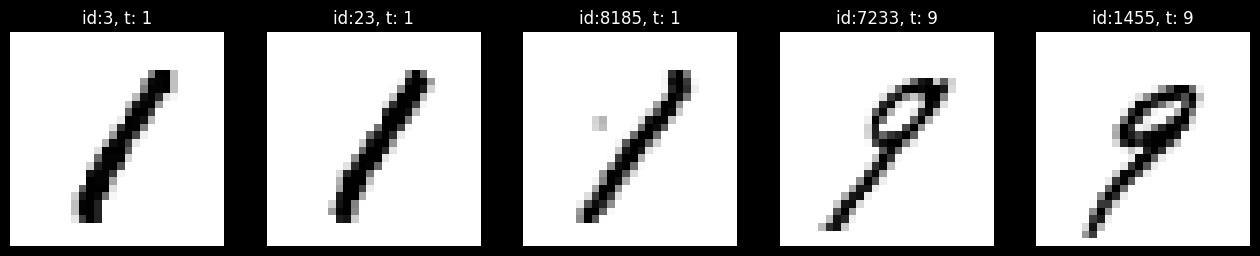

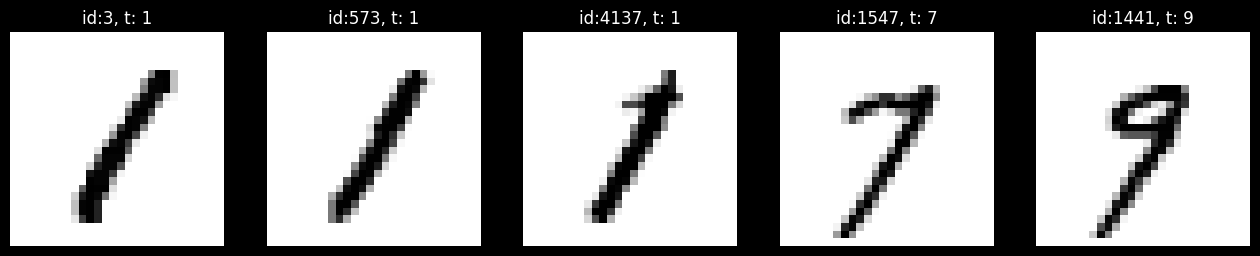

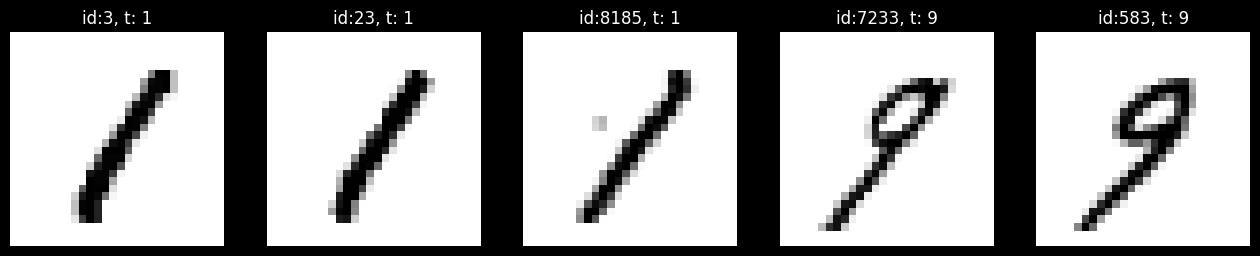

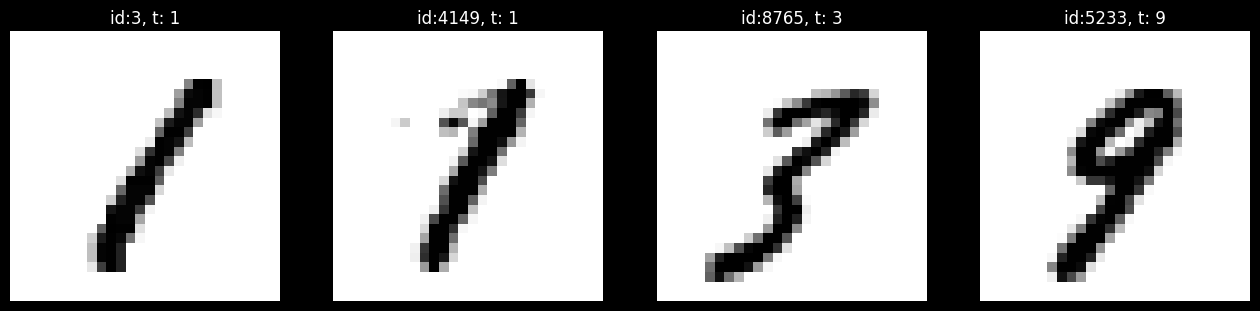

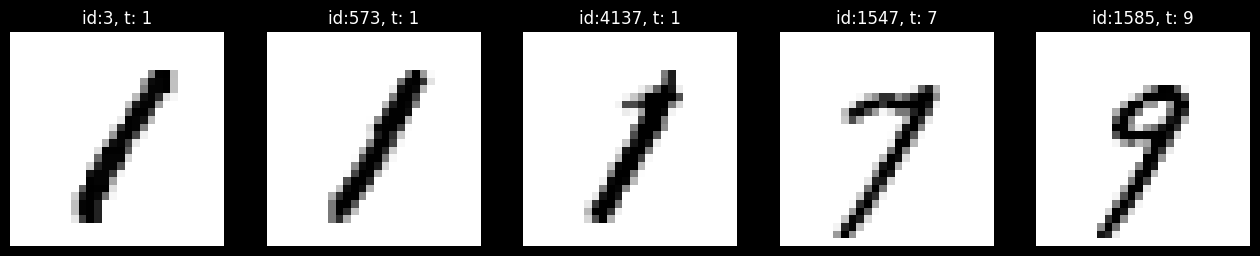

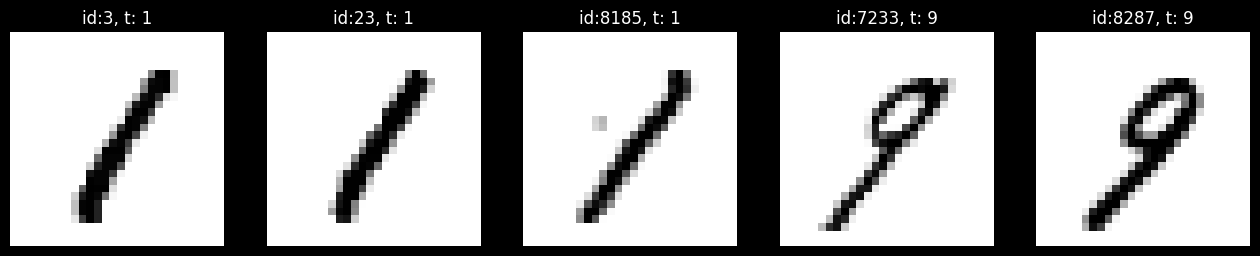

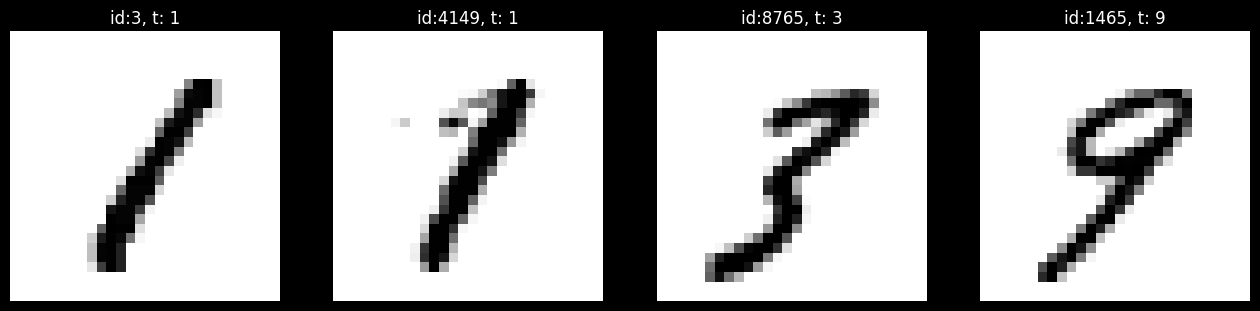

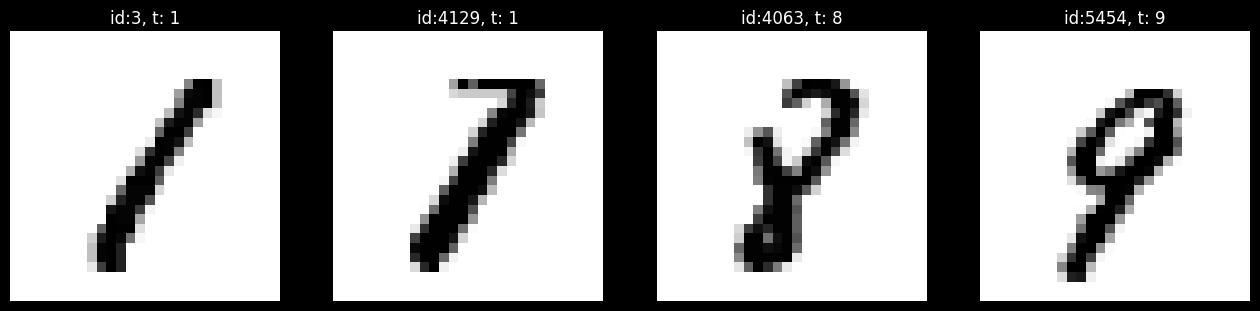

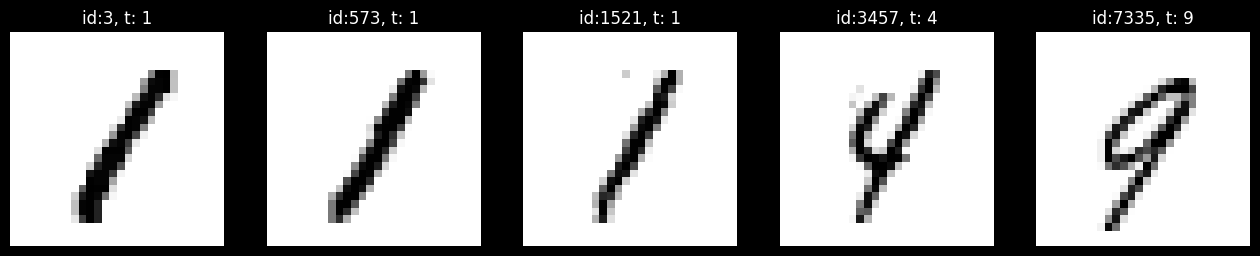

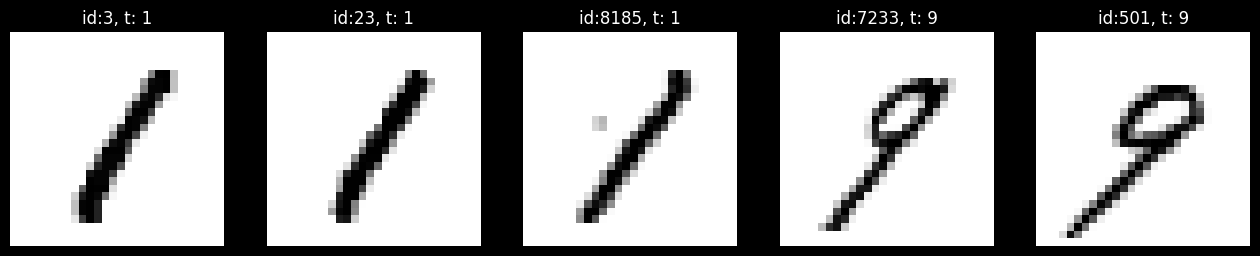

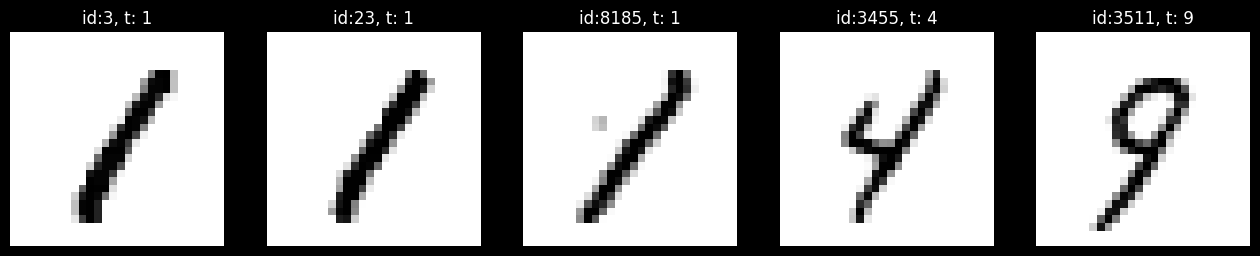

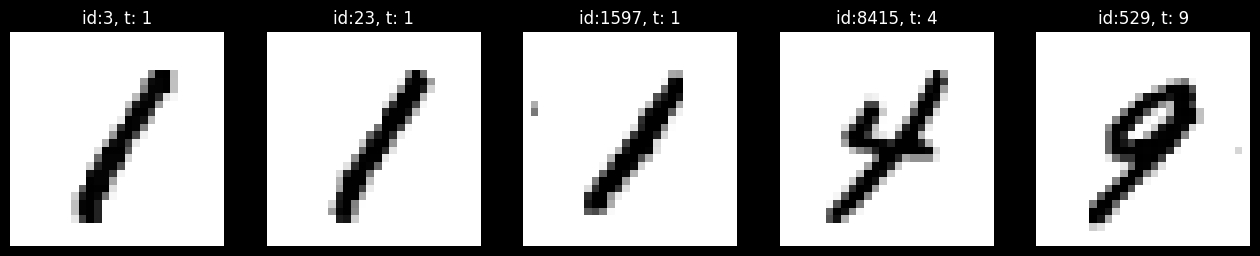

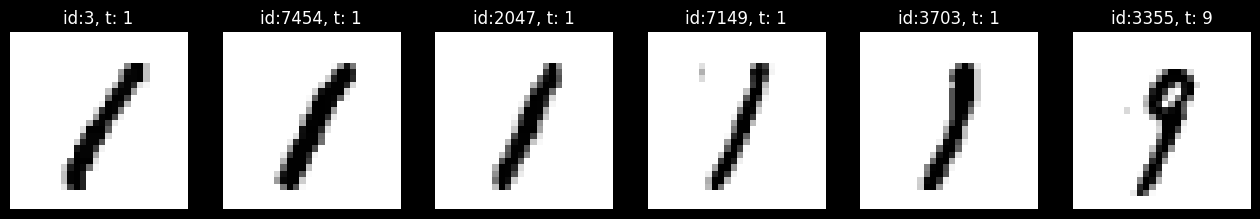

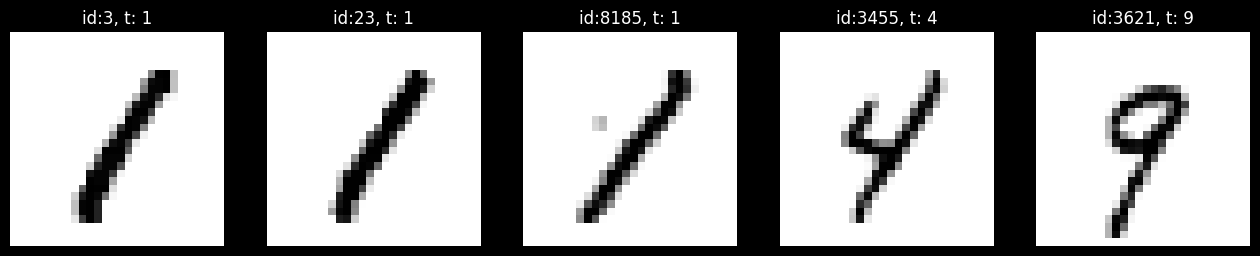

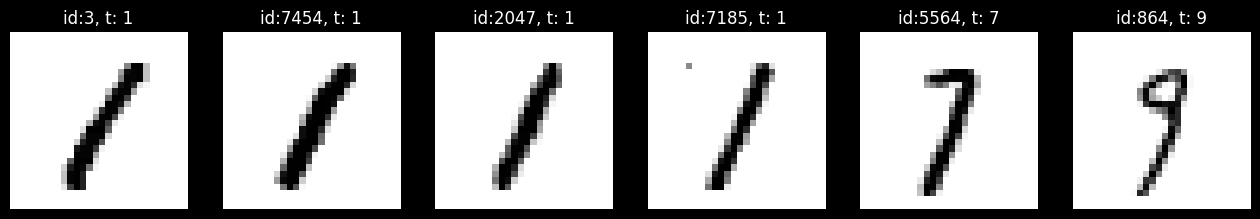

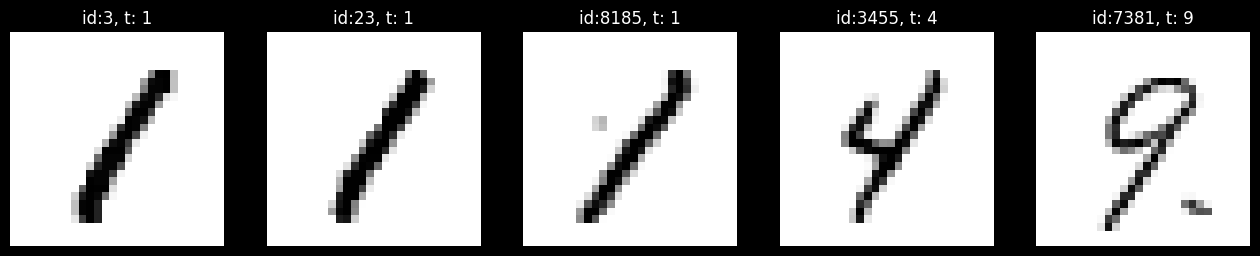

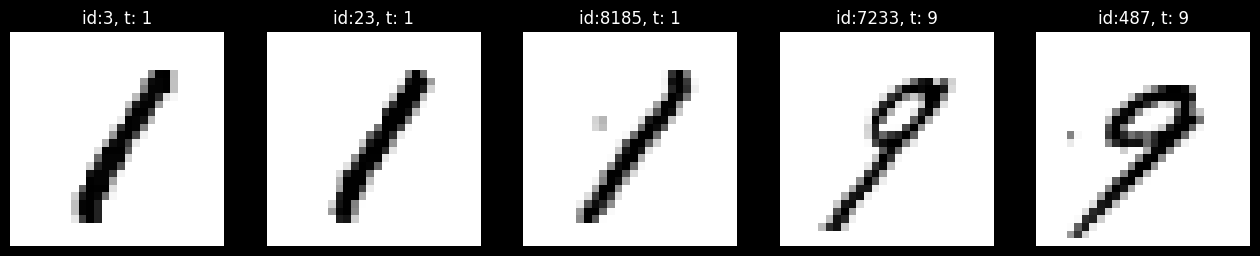

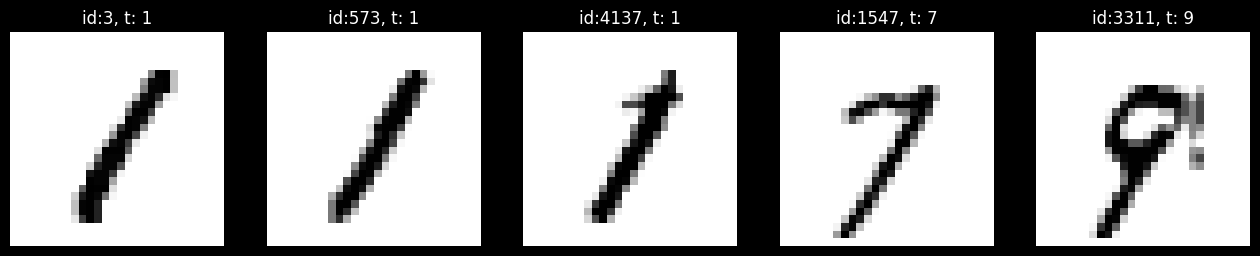

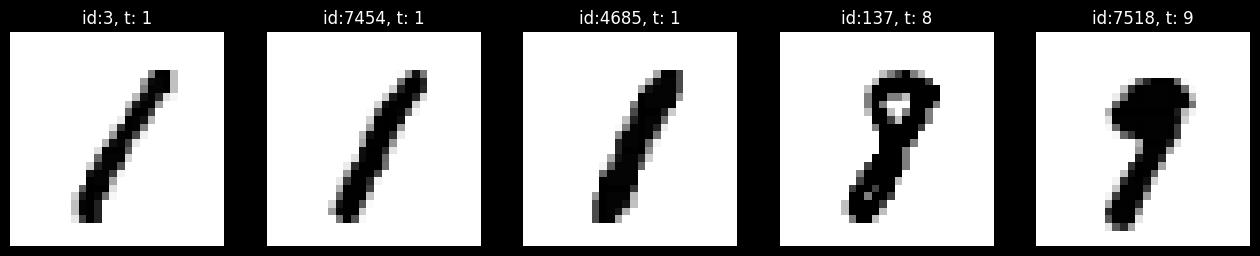

In [21]:
res = all_paths
for k in res.keys():
    for k2 in res[k].keys():
        plot_digits(res[k][k2])
